cross entropy loss　分類問題

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks/"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更してね。

In [3]:
%cd "ctorch210929/MiniCTorch_Prototype/jpynb"

/content/drive/My Drive/Colab Notebooks/ctorch210929/MiniCTorch_Prototype/jpynb


In [4]:
! pip install lark-parser

     |████████████████████████████████| 103 kB 5.9 MB/s 


In [5]:
import sys
sys.path.append("../minictorch")

import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import generator as GN
import converter as CV

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

データ読み込み

In [7]:
# データ読み込み
iris = datasets.load_iris()
data   = iris['data']
target = iris['target']

# 学習データと検証データに分割
x_train, x_valid, y_train, y_valid = train_test_split( data, target, shuffle=True )

# 特徴量の標準化
scaler = StandardScaler()
scaler.fit( x_train )

x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)

# Tensor型に変換
# 学習に入れるときはfloat型 or long型になっている必要があるのここで変換してしまう
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(y_valid).long()

#print('x_train : ', x_train.shape)
#print('y_train : ', y_train.shape)
#print('x_valid : ', x_valid.shape)
#print('y_valid : ', y_valid.shape)

DataSetとDataLoaderの生成

In [8]:
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)

# indexを指定すればデータを取り出すことができます。
index = 0
print( train_dataset.__getitem__(index)[0].size() )
print( train_dataset.__getitem__(index)[1] )


batch_size = 112
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 動作確認
# こんな感じでバッチ単位で取り出す子ができます。
# イテレータに変換
batch_iterator = iter(train_dataloader)

# 1番目の要素を取り出す
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels.size())
print(inputs)
print(labels)

torch.Size([4])
tensor(2)
torch.Size([112, 4])
torch.Size([112])
tensor([[-1.1056e+00, -1.4971e+00, -2.2779e-01, -2.1464e-01],
        [ 7.0825e-01,  2.9863e-01,  9.2402e-01,  1.5610e+00],
        [-8.6372e-01, -1.2727e+00, -4.0056e-01, -7.8050e-02],
        [ 9.5010e-01, -3.7479e-01,  5.2089e-01,  1.9512e-01],
        [-1.3820e-01,  2.9923e+00, -1.2644e+00, -1.0342e+00],
        [-9.8464e-01,  2.9863e-01, -1.4372e+00, -1.3073e+00],
        [ 5.8733e-01, -1.2727e+00,  7.5125e-01,  1.0146e+00],
        [ 2.2457e-01, -1.9461e+00,  7.5125e-01,  4.6830e-01],
        [ 1.4338e+00,  2.9863e-01,  5.7848e-01,  3.3171e-01],
        [-3.8004e-01, -1.2727e+00,  1.7534e-01,  1.9512e-01],
        [-1.1056e+00,  1.1965e+00, -1.3220e+00, -1.4439e+00],
        [ 8.2917e-01, -1.5032e-01,  8.6643e-01,  1.1512e+00],
        [ 1.0710e+00,  5.2310e-01,  1.1544e+00,  1.8342e+00],
        [ 1.1919e+00, -5.9926e-01,  6.3607e-01,  3.3171e-01],
        [ 3.4549e-01, -1.0482e+00,  1.0968e+00,  3.3171e-01],
     

ニューラルネットワークの定義

In [9]:
class Net(nn.Module):    
    def __init__(self,t):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 3)
        self.target = t
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = F.log_softmax(x, dim=1)
        #return x
        
        #print(x);
        #print(self.target);
        self.out = x

        loss = nn.CrossEntropyLoss()
        #loss = nn.NLLLoss()
        output = loss(x,self.target)
        return output
        

class Net2(nn.Module):    
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 3)
        #self.fc1 = nn.Linear(4, 128)
        #self.fc2 = nn.Linear(128, 3)
        #self.fc3 = nn.Linear(64, 3)
        #self.fc4 = nn.Linear(128, 3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = self.fc2(x)
        #x = F.softmax(x, dim=1)
        return x

In [10]:
def generate_json( json_path, input, target ):

    model = Net( target )
    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

In [11]:
torch.manual_seed( 1 )

print("inputs",inputs)
print("target",labels)
inputs.requires_grad = True

project = 'cse1'
json_path = '../network/' + project +'.json'

model = generate_json( json_path, inputs, labels )

with torch.set_grad_enabled(True):

  output = model( inputs )
  print("output",output)

  model.zero_grad()
  #torch.zeros_like(inputs.grad)

  output.backward()
  print("output grad",output.grad)
  #print("fc1 grad",model.fc1.weight.grad)
  #print("fc2 grad",model.fc2.weight.grad)
  print("input grad",inputs.grad)

  # ラベルを予測
  #print("output", model.out, inputs.size(0))
  _, preds = torch.max( model.out, 1 )

  # イテレーション結果の計算
  epoch_loss = output * inputs.size(0)

  # 正解数の合計を更新
  epoch_corrects = torch.sum( preds == labels.data )

  epoch_loss = epoch_loss / float(inputs.size(0))
  epoch_acc  = epoch_corrects.double() / float(inputs.size(0))

  epoch=1
  print('Train Loss {}: {:.4f} Acc: {:.4f}'.format( epoch, epoch_loss, epoch_acc ))

inputs tensor([[-1.1056e+00, -1.4971e+00, -2.2779e-01, -2.1464e-01],
        [ 7.0825e-01,  2.9863e-01,  9.2402e-01,  1.5610e+00],
        [-8.6372e-01, -1.2727e+00, -4.0056e-01, -7.8050e-02],
        [ 9.5010e-01, -3.7479e-01,  5.2089e-01,  1.9512e-01],
        [-1.3820e-01,  2.9923e+00, -1.2644e+00, -1.0342e+00],
        [-9.8464e-01,  2.9863e-01, -1.4372e+00, -1.3073e+00],
        [ 5.8733e-01, -1.2727e+00,  7.5125e-01,  1.0146e+00],
        [ 2.2457e-01, -1.9461e+00,  7.5125e-01,  4.6830e-01],
        [ 1.4338e+00,  2.9863e-01,  5.7848e-01,  3.3171e-01],
        [-3.8004e-01, -1.2727e+00,  1.7534e-01,  1.9512e-01],
        [-1.1056e+00,  1.1965e+00, -1.3220e+00, -1.4439e+00],
        [ 8.2917e-01, -1.5032e-01,  8.6643e-01,  1.1512e+00],
        [ 1.0710e+00,  5.2310e-01,  1.1544e+00,  1.8342e+00],
        [ 1.1919e+00, -5.9926e-01,  6.3607e-01,  3.3171e-01],
        [ 3.4549e-01, -1.0482e+00,  1.0968e+00,  3.3171e-01],
        [ 1.0365e-01,  2.9863e-01,  6.3607e-01,  8.7806e-01],
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.


In [ ]:
"""
def convert_json( project, folder, model, input_x, json_path, rand_flag=0 ):

    #folder = "src"
    cpp_fname   = project + ".cpp"
    param_fname = project + "_param.cpp"
    cpp_path    = folder + "/" + cpp_fname
    param_path  = folder + "/" + param_fname
    make_path   = folder + "/" + "Makefile"

    # load json file
    print( "[JSON]", json_path )
    fp = open( json_path )
    obj = json.load( fp )

    # save parameter file
    code1 = CV.c_param_generator( obj, model, input_x )
    if len( code1 ) > 0:
       print( "[PARAM]", param_path )
       ofparam = open( param_path, "w" )
       ofparam.write( code1 )

    # save cpp file
    print( "[CPP]  ", cpp_path )
    code2 = CV.c_code_generator( obj, model, rand_flag )

    #ofp=open(args.path+"/"+args.output,"w")
    ofp = open( cpp_path, "w" )
    ofp.write( code2 )

    # save make file
    print( "[MAKE] ", make_path )
    make_code = CV.makefile_generator( cpp_fname )

    #makefp=open(args.path+"/"+"Makefile","w")
    makefp = open( make_path, "w" )
    makefp.write( make_code )
"""

In [12]:
CV.convert_json( project, "../src", model, inputs, json_path )

[JSON] ../network/cse1.json
{'name': 'Net/Linear[fc1]/weight/35', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'Net/Linear[fc1]/bias/34', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'Net/Linear[fc2]/weight/38', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'Net/Linear[fc2]/bias/37', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
[PARAM] ../src/cse1_param.cpp
{'name': 'input/x', 'op': 'IO Node', 'in': [], 'output_id': 0, 'shape': [112, 4], 'out': [3], 'sorted_id': 0}
{'name': 'Net/Linear[fc1]/weight/35', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
Net/Linear[fc1]/weight/35  ->  fc1_weight
{'name': 'Net/Linear[fc1]/bias/34', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
Net/Linear[fc1]/bias/34  -> 

In [14]:
!g++ -std=c++14 ../src/cse1.cpp ../src/cse1_param.cpp -I ../../../ctorch/lib -lcblas -o ../bin/cse1

(注意) ctorch/libにxtensor関連のincludeを置いています。

In [16]:
!../bin/cse1

### forward computation ...
 1.153184
### backward computation ...
input_grad{{ 0.000793, -0.000574,  0.001371,  0.000527},
 { 0.000284,  0.000963, -0.000375,  0.000862},
 { 0.000984, -0.000376,  0.0012  ,  0.00046 },
 {-0.00061 , -0.000131, -0.000271, -0.001259},
 {-0.001707,  0.000773,  0.000828,  0.000449},
 {-0.001325, -0.000645,  0.000298, -0.000357},
 { 0.001163,  0.000691, -0.000996,  0.000737},
 { 0.000553,  0.000182, -0.001149,  0.000162},
 {-0.000522, -0.000137, -0.00066 , -0.00123 },
 { 0.000571,  0.00024 ,  0.000556, -0.000137},
 {-0.001414, -0.000582,  0.000327, -0.000333},
 { 0.00045 ,  0.001247, -0.000931,  0.000983},
 { 0.00021 ,  0.001021,  0.000031,  0.0007  },
 {-0.000825, -0.000137, -0.000594, -0.000532},
 { 0.001373,  0.000725, -0.001057,  0.000911},
 { 0.000024, -0.000669, -0.000309, -0.00159 },
 { 0.001358,  0.001015, -0.000167,  0.000026},
 {-0.001463, -0.000611,  0.000429, -0.000323},
 { 0.000517,  0.000186,  0.000667,  0.000138},
 { 0.001107,  0.001054, -0.000

In [17]:
torch.manual_seed( 1 )

#print("target",target)
inputs.requires_grad = True

#model = Net( labels )
model = Net2()

num = inputs.size(0)

project = 'test5'
#json_path = 'network/' + project +'.json'

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( model.parameters(), lr=0.01 )

num_epochs = 300

acc = []

for epoch in range(num_epochs):
  with torch.set_grad_enabled(True):

    model.train()   # モデルを訓練モードに設定

    outputs = model( inputs )
    #print(outputs)
    #print(labels)

    #print("input grad",inputs.grad)

    loss = criterion( outputs, labels )
    print("loss ",epoch, " - ",loss)

    # ラベルを予測
    #print("output", outputs, num )
    _, preds = torch.max( outputs, 1 )
    #print(labels)
    #print(preds)

    optimizer.zero_grad()

    # 逆伝搬の計算
    loss.backward()
                    
    # パラメータの更新
    optimizer.step()

    # イテレーション結果の計算
    epoch_loss = loss.item() * float(num)

    # 正解数の合計を更新
    epoch_corrects = torch.sum( preds == labels )

    epoch_loss = epoch_loss / float(num)
    epoch_acc  = epoch_corrects.double() / float(num)
    print('Train Loss {}: {:.4f} Acc: {:.4f} {}'.format( epoch, epoch_loss, epoch_acc, epoch_corrects ))

    acc.append( epoch_acc )

loss  0  -  tensor(1.1532, grad_fn=<NllLossBackward>)
Train Loss 0: 1.1532 Acc: 0.1786 20
loss  1  -  tensor(1.1300, grad_fn=<NllLossBackward>)
Train Loss 1: 1.1300 Acc: 0.1786 20
loss  2  -  tensor(1.1077, grad_fn=<NllLossBackward>)
Train Loss 2: 1.1077 Acc: 0.1607 18
loss  3  -  tensor(1.0862, grad_fn=<NllLossBackward>)
Train Loss 3: 1.0862 Acc: 0.1607 18
loss  4  -  tensor(1.0656, grad_fn=<NllLossBackward>)
Train Loss 4: 1.0656 Acc: 0.1607 18
loss  5  -  tensor(1.0458, grad_fn=<NllLossBackward>)
Train Loss 5: 1.0458 Acc: 0.1786 20
loss  6  -  tensor(1.0268, grad_fn=<NllLossBackward>)
Train Loss 6: 1.0268 Acc: 0.1964 22
loss  7  -  tensor(1.0086, grad_fn=<NllLossBackward>)
Train Loss 7: 1.0086 Acc: 0.2143 24
loss  8  -  tensor(0.9910, grad_fn=<NllLossBackward>)
Train Loss 8: 0.9910 Acc: 0.2768 31
loss  9  -  tensor(0.9742, grad_fn=<NllLossBackward>)
Train Loss 9: 0.9742 Acc: 0.3214 36
loss  10  -  tensor(0.9581, grad_fn=<NllLossBackward>)
Train Loss 10: 0.9581 Acc: 0.4107 46
loss  11

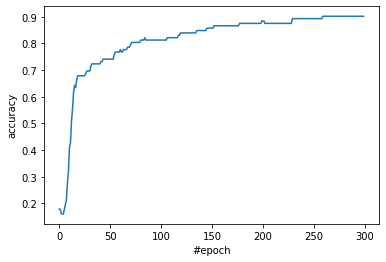

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(acc))),acc )
ax.set_xlabel('#epoch')
ax.set_ylabel('accuracy')
fig.show()

C++のコードは手作業で修正しています。

In [19]:
!g++ -std=c++14 ../src/cse1_opt.cpp ../src/cse1_param.cpp -I ../../../ctorch/lib -lblas -o ../bin/cse1_opt

In [20]:
!../bin/cse1_opt

### forward computation ...
get_classes
epoch 0 - loss 1.15318 - accuracy 0.178571
### backward computation ...
### forward computation ...
get_classes
epoch 1 - loss 1.12999 - accuracy 0.178571
### backward computation ...
### forward computation ...
get_classes
epoch 2 - loss 1.10768 - accuracy 0.160714
### backward computation ...
### forward computation ...
get_classes
epoch 3 - loss 1.08623 - accuracy 0.160714
### backward computation ...
### forward computation ...
get_classes
epoch 4 - loss 1.06561 - accuracy 0.160714
### backward computation ...
### forward computation ...
get_classes
epoch 5 - loss 1.04581 - accuracy 0.178571
### backward computation ...
### forward computation ...
get_classes
epoch 6 - loss 1.0268 - accuracy 0.196429
### backward computation ...
### forward computation ...
get_classes
epoch 7 - loss 1.00855 - accuracy 0.214286
### backward computation ...
### forward computation ...
get_classes
epoch 8 - loss 0.991038 - accuracy 0.276786
### backward computat

In [21]:
f = open('./cse1.out', 'r')

loss = []
acc=[]

datalist = f.readlines()
for data in datalist:
  #print(data)
  ds = data.split(',')
  loss.append( float(ds[0]) )
  acc.append( float(ds[1]) )

f.close()

print("epoch =", len(loss))
print( loss )

epoch = 300
[1.153184, 1.129989, 1.107678, 1.086227, 1.065614, 1.045813, 1.026801, 1.008551, 0.991038, 0.974234, 0.958115, 0.942649, 0.927813, 0.913579, 0.899921, 0.886814, 0.874234, 0.862156, 0.850557, 0.839412, 0.8287, 0.8184, 0.808493, 0.798958, 0.789777, 0.780932, 0.772408, 0.764188, 0.756256, 0.748598, 0.741201, 0.734051, 0.727136, 0.720446, 0.713968, 0.707693, 0.701611, 0.695713, 0.68999, 0.684434, 0.679037, 0.673792, 0.668692, 0.663731, 0.658902, 0.654201, 0.64962, 0.645155, 0.640802, 0.636555, 0.63241, 0.628362, 0.624409, 0.620545, 0.616769, 0.613075, 0.609461, 0.605924, 0.602461, 0.599069, 0.595746, 0.592489, 0.589296, 0.586165, 0.583093, 0.580079, 0.577121, 0.574216, 0.571363, 0.568561, 0.565807, 0.563101, 0.56044, 0.557824, 0.555251, 0.55272, 0.550229, 0.547778, 0.545364, 0.542988, 0.540649, 0.538345, 0.536075, 0.533838, 0.531634, 0.529461, 0.52732, 0.525208, 0.523126, 0.521073, 0.519048, 0.517049, 0.515078, 0.513132, 0.511212, 0.509317, 0.507445, 0.505598, 0.503774, 0.50197

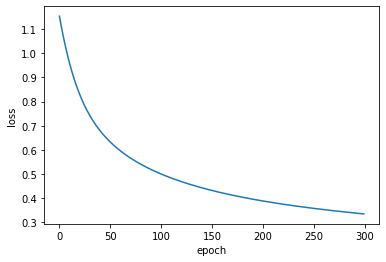

In [22]:
# 交差エントロピー誤差
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(loss))), loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

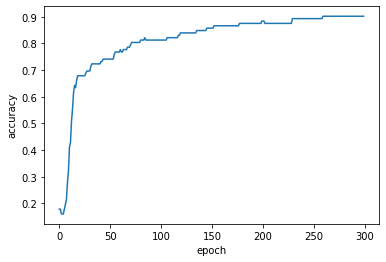

In [23]:
# 正解率
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(acc))), acc)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
fig.show()